<a href="https://colab.research.google.com/github/ribesstefano/chalmers_dat450_ml_for_nlp/blob/main/A4_Biomedical_Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to the Assignment Instructions](http://www.cse.chalmers.se/~richajo/dat450/assignments/assignment4.html)

# Authors

* Stefano Ribes
* Cody Hesse
* Albin Jansfelt

This notebook can also be viewed at this link: https://drive.google.com/file/d/1y8L9S7WLQnvxjmD0lNI8P7sW9ZQibv4M/view?usp=sharing

## For Colab users

Uncomment the following to install the Transformers library (only necessary if you solve the second optional task).

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 19.2 MB/s 
     |████████████████████████████████| 182 kB 74.5 MB/s 
     |████████████████████████████████| 7.6 MB 61.7 MB/s 


We get the helper Python file and the files containing the training and validation data.

In [ ]:
!rm -f *py *tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/train.tsv
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/devel.tsv

# If you have trouble downloading from github, instead get them from
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/devel.tsv

--2022-12-08 16:16:42--  http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25178 (25K) [text/plain]
Saving to: ‘ner_util.py’

ner_util.py         100%[===================>]  24.59K   113KB/s    in 0.2s    

2022-12-08 16:16:43 (113 KB/s) - ‘ner_util.py’ saved [25178/25178]

--2022-12-08 16:16:43--  http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1039940 (1016K) [text/tab-separated-values]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   1016K   280KB/s    in 3.6s    

2022-12-08 16:16:47 (280 KB/s) - ‘train.ts

# Solution template for Assignment 4

This is the template notebook for Assignment 4.

The infrastructure code (vocabulary management, training loop, word embedding loading, evaluation, etc) has been moved into a separate file <code>ner_util.py</code> you can get [here](http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py). Download this file and put it into the same directory as where you are executing your notebook. Import this file and you are ready to go.

In [ ]:
import ner_util

## Reading the data in a tabular format

The following function reads a file represented in a tabular format. In this format, each row corresponds to one token. For each token, there is a word and the BIO-coded named entity label, separated by whitespace. The sentences are separated by empty lines. Here is an example of a sentence.
```
In              O
conclusion      O
,               O
hyperammonemic  B-Disease
encephalopathy  I-Disease
can             O
occur           O
in              O
patients        O
receiving       O
continuous      O
infusion        O
of              O
5               B-Chemical
-               I-Chemical
FU              I-Chemical
.               O
```
The function `ner_util.read_data` reads the file in this format and returns sentences and their corresponding BIO labels.

In [ ]:
Xtrain, Ytrain = ner_util.read_data('train.tsv')
Xval, Yval = ner_util.read_data('devel.tsv')

An example:

In [ ]:
Xtrain[100]

['High',
 'doses',
 'of',
 'vitamin',
 'D',
 'are',
 'known',
 'to',
 'cause',
 'calcification',
 'of',
 'the',
 'artery',
 'media',
 'in',
 'as',
 'little',
 'as',
 '3',
 'to',
 '4',
 'days',
 '.']

In [ ]:
Ytrain[100]

['O',
 'O',
 'O',
 'B-Chemical',
 'I-Chemical',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

## Baseline sequence labeling model

This is the baseline model. You can expand on this when implementing your solution.

In [ ]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # The argument words is a tensor of integer-encoded words, with shape
        # (batch_size, max_sen_length)      
        # After embedding the words, the shape is:
        # (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(word_repr)

## Training the system

As usual, we create an object that contains all hyperparameters.

In [ ]:
class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 0    
    
    # cuda or cpu
    device = 'cuda'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

    # LSTM Hidden size
    hidden_size = 64
    lstm_n_layers = 2

    # BERT_MAX_SIZE
    bert_max_len = 128

Now, we are ready to train. When creating the NER system, the first argument should be the hyperparameter container. The second should be a function that builds the neural network; we just use the constructor of the class we defined above.

In [ ]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 1.1238, val f1: 0.1077, time = 0.5072
Epoch 2: train loss = 0.7464, val f1: 0.0617, time = 0.4960
Epoch 3: train loss = 0.5754, val f1: 0.0220, time = 0.4940
Epoch 4: train loss = 0.5067, val f1: 0.0311, time = 0.5013
Epoch 5: train loss = 0.4781, val f1: 0.0247, time = 0.4950
Epoch 6: train loss = 0.4647, val f1: 0.0192, time = 0.5149
Epoch 7: train loss = 0.4562, val f1: 0.0058, time = 0.4874
Epoch 8: train loss = 0.4520, val f1: 0.0264, time = 0.5087
Epoch 9: train loss = 0.4480, val f1: 0.0205, time = 0.4995
Epoch 10: train loss = 0.4446, val f1: 0.0060, time = 0.5082
Epoch 11: train loss = 0.4430, val f1: 0.0136, time = 0.5081
Epoch 12: train loss = 0.4421, val f1: 0.0142, time = 0.5079
Epoch 13: train loss = 0.4415, val f1: 0.0169, time = 0.4968
Epoch 14: train loss = 0.4404, val f1: 0.0012, time = 0.5227
Epoch 15: train loss = 0.4380, val f1: 0.0024, time = 0.5169
Epoch 16: train loss = 0.4377, val f1: 0.0098, time = 0.5025
Epoch 17: train loss = 0.4383, va

0.10774507002000572

Optionally, plot the training loss and validation F-score over the epochs.

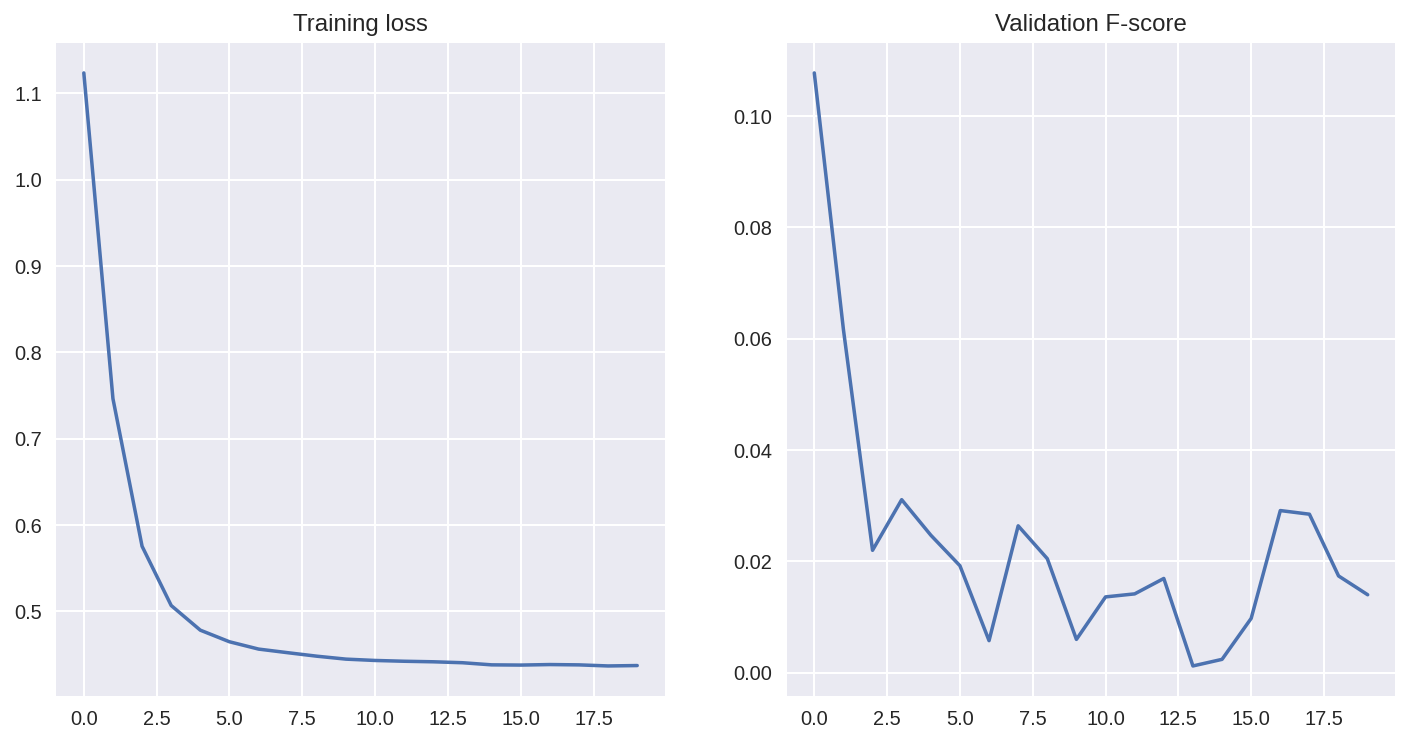

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')
plt.show()

Predicting outputs:

In [ ]:
ner_system.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [ ]:
ner_util.show_entities(ner_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

### RNN 

In [ ]:
import torch
from torch import nn

class RNNSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding
        # layer.        
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]
        self.rnn = nn.LSTM(input_size=word_emb_dim, hidden_size=p.hidden_size,
                           num_layers=p.lstm_n_layers, batch_first=True,
                           bidirectional=True)
        # Output unit.
        self.top_layer = nn.Linear(p.hidden_size * 2, seq_labeler.n_labels)
                        
    def forward(self, words):
        # The argument words is a tensor of integer-encoded words, with shape
        # (batch_size, max_sen_length)
        word_repr = self.word_embedding(words)
        # After embedding the words, the shape is (batch_size, max_sen_length,
        # emb_dim). 
        x, _ = self.rnn(word_repr)
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(x)

In [ ]:
ner_system_rnn = ner_util.SequenceLabeler(NERParameters(), RNNSequenceModel)
ner_system_rnn.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.4229, val f1: 0.4505, time = 1.0077
Epoch 2: train loss = 0.1560, val f1: 0.5711, time = 0.9890
Epoch 3: train loss = 0.0760, val f1: 0.5958, time = 0.9946
Epoch 4: train loss = 0.0369, val f1: 0.6016, time = 0.9914
Epoch 5: train loss = 0.0240, val f1: 0.6126, time = 1.0220
Epoch 6: train loss = 0.0137, val f1: 0.6284, time = 0.9995
Epoch 7: train loss = 0.0108, val f1: 0.6252, time = 1.0134
Epoch 8: train loss = 0.0100, val f1: 0.6304, time = 0.9938
Epoch 9: train loss = 0.0075, val f1: 0.6403, time = 1.0189
Epoch 10: train loss = 0.0069, val f1: 0.6386, time = 1.0108
Epoch 11: train loss = 0.0054, val f1: 0.6423, time = 1.0003
Epoch 12: train loss = 0.0081, val f1: 0.6502, time = 0.9950
Epoch 13: train loss = 0.0082, val f1: 0.6210, time = 1.0104
Epoch 14: train loss = 0.0087, val f1: 0.6511, time = 0.9885
Epoch 15: train loss = 0.0067, val f1: 0.6641, time = 0.9857
Epoch 16: train loss = 0.0093, val f1: 0.6488, time = 1.0019
Epoch 17: train loss = 0.0085, va

0.6640624999999999

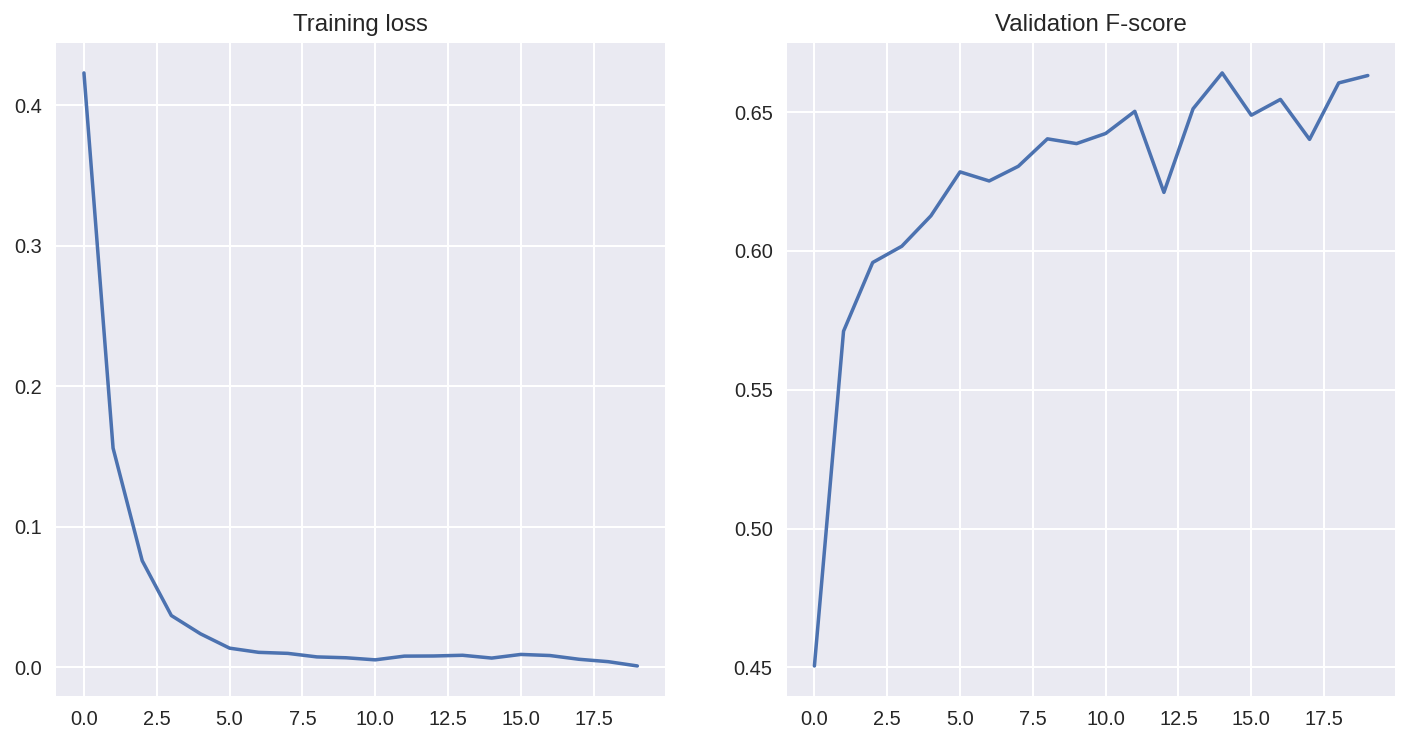

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system_rnn.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system_rnn.history['val_f1']);
ax[1].set_title('Validation F-score')
plt.show()

In [ ]:
ner_system_rnn.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [ ]:
ner_util.show_entities(ner_system_rnn, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

### Investigating the word embedding model

In [ ]:
model_f1_scores = {}

#### Repeated experiments

In [ ]:
import random

def repeat_train(ner_system, runs=5, verbose=1):
    f1_scores = []
    for i in range(runs):
        ner_system.params.random_seed += i
        print(f'{"-" * 80}\nIteration n.{i}\n{"-" * 80}')
        f1_scores.append(ner_system.fit(Xtrain, Ytrain, Xval, Yval))
        print(f'{"-" * 80}\nIteration n.{i} complete\n{"-" * 80}')
    return sum(f1_scores) / len(f1_scores)

In [ ]:
ner_system = ner_util.SequenceLabeler(NERParameters(), RNNSequenceModel)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN Without Finetuning'] = avg_f1

Epoch 1: train loss = 0.4229, val f1: 0.4505, time = 1.0216
Epoch 2: train loss = 0.1560, val f1: 0.5711, time = 1.0025
Epoch 3: train loss = 0.0760, val f1: 0.5958, time = 1.0157
Epoch 4: train loss = 0.0369, val f1: 0.6016, time = 1.0138
Epoch 5: train loss = 0.0240, val f1: 0.6126, time = 1.0164
Epoch 6: train loss = 0.0137, val f1: 0.6284, time = 1.0335
Epoch 7: train loss = 0.0108, val f1: 0.6252, time = 1.0374
Epoch 8: train loss = 0.0100, val f1: 0.6304, time = 1.0176
Epoch 9: train loss = 0.0075, val f1: 0.6403, time = 1.0115
Epoch 10: train loss = 0.0069, val f1: 0.6386, time = 1.0149
Epoch 11: train loss = 0.0054, val f1: 0.6423, time = 1.0286
Epoch 12: train loss = 0.0081, val f1: 0.6502, time = 1.0086
Epoch 13: train loss = 0.0082, val f1: 0.6210, time = 1.0176
Epoch 14: train loss = 0.0087, val f1: 0.6511, time = 1.0163
Epoch 15: train loss = 0.0067, val f1: 0.6641, time = 0.9967
Epoch 16: train loss = 0.0093, val f1: 0.6488, time = 1.0660
Epoch 17: train loss = 0.0085, va

#### Fine-tuning the word embedding model

In [ ]:
params = NERParameters()
params.finetune_word_emb = True
ner_system_finetuned = ner_util.SequenceLabeler(params, RNNSequenceModel)
avg_f1 = repeat_train(ner_system_finetuned, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN With Finetuning'] = avg_f1

Epoch 1: train loss = 0.3856, val f1: 0.5454, time = 1.0544
Epoch 2: train loss = 0.1090, val f1: 0.6581, time = 1.0587
Epoch 3: train loss = 0.0453, val f1: 0.6828, time = 1.0757
Epoch 4: train loss = 0.0195, val f1: 0.6789, time = 1.0501
Epoch 5: train loss = 0.0075, val f1: 0.6899, time = 1.0518
Epoch 6: train loss = 0.0032, val f1: 0.6929, time = 1.0640
Epoch 7: train loss = 0.0014, val f1: 0.6916, time = 1.0645
Epoch 8: train loss = 0.0010, val f1: 0.6732, time = 1.0632
Epoch 9: train loss = 0.0005, val f1: 0.6849, time = 1.0463
Epoch 10: train loss = 0.0002, val f1: 0.6836, time = 1.0315
Epoch 11: train loss = 0.0001, val f1: 0.6837, time = 1.0487
Epoch 12: train loss = 0.0001, val f1: 0.6843, time = 1.0429
Epoch 13: train loss = 0.0001, val f1: 0.6846, time = 1.0256
Epoch 14: train loss = 0.0000, val f1: 0.6848, time = 1.0538
Epoch 15: train loss = 0.0000, val f1: 0.6851, time = 1.0367
Epoch 16: train loss = 0.0000, val f1: 0.6845, time = 1.0424
Epoch 17: train loss = 0.0000, va

#### Loading a pre-trained word embedding model from `gensim`

Run the NER system again, this time providing the output from load_gensim_vectors as the input to the tagger via the pretrained_word_emb argument. Compute the mean F1 over 5 runs again, once with a "frozen" word embedding model and once with fine-tuning. Record the results in a table. 

In [ ]:
glove = ner_util.load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)

[==================================================] 100.0% 128.1/128.1MB downloaded
 done!


In [ ]:
params = NERParameters()
ner_system = ner_util.SequenceLabeler(params, RNNSequenceModel,
                                      pretrained_word_emb=glove)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN using GloVe Without Finetuning'] = avg_f1

Epoch 1: train loss = 0.3215, val f1: 0.6657, time = 1.0212
Epoch 2: train loss = 0.1384, val f1: 0.7193, time = 1.0279
Epoch 3: train loss = 0.0997, val f1: 0.7300, time = 1.0167
Epoch 4: train loss = 0.0759, val f1: 0.7702, time = 1.0174
Epoch 5: train loss = 0.0614, val f1: 0.7494, time = 0.9990
Epoch 6: train loss = 0.0454, val f1: 0.7696, time = 0.9877
Epoch 7: train loss = 0.0331, val f1: 0.7631, time = 0.9963
Epoch 8: train loss = 0.0286, val f1: 0.7742, time = 0.9941
Epoch 9: train loss = 0.0176, val f1: 0.7734, time = 1.0167
Epoch 10: train loss = 0.0157, val f1: 0.7763, time = 1.0062
Epoch 11: train loss = 0.0115, val f1: 0.7711, time = 1.0089
Epoch 12: train loss = 0.0081, val f1: 0.7630, time = 0.9817
Epoch 13: train loss = 0.0090, val f1: 0.7559, time = 0.9867
Epoch 14: train loss = 0.0141, val f1: 0.7603, time = 0.9871
Epoch 15: train loss = 0.0145, val f1: 0.7735, time = 1.0458
Epoch 16: train loss = 0.0115, val f1: 0.7789, time = 1.0206
Epoch 17: train loss = 0.0081, va

In [ ]:
params = NERParameters()
params.finetune_word_emb = True
ner_system = ner_util.SequenceLabeler(params, RNNSequenceModel,
                                      pretrained_word_emb=glove)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN using GloVe With Finetuning'] = avg_f1

Epoch 1: train loss = 0.2872, val f1: 0.7300, time = 3.1832
Epoch 2: train loss = 0.0846, val f1: 0.7494, time = 3.1639
Epoch 3: train loss = 0.0504, val f1: 0.7607, time = 3.1483
Epoch 4: train loss = 0.0329, val f1: 0.7864, time = 3.1783
Epoch 5: train loss = 0.0217, val f1: 0.7707, time = 3.1607
Epoch 6: train loss = 0.0139, val f1: 0.7751, time = 3.1536
Epoch 7: train loss = 0.0108, val f1: 0.7777, time = 3.1538
Epoch 8: train loss = 0.0061, val f1: 0.7774, time = 3.1517
Epoch 9: train loss = 0.0047, val f1: 0.7677, time = 3.1610
Epoch 10: train loss = 0.0026, val f1: 0.7720, time = 3.1601
Epoch 11: train loss = 0.0018, val f1: 0.7766, time = 3.1853
Epoch 12: train loss = 0.0016, val f1: 0.7785, time = 3.4421
Epoch 13: train loss = 0.0011, val f1: 0.7802, time = 3.2031
Epoch 14: train loss = 0.0018, val f1: 0.7663, time = 3.1608
Epoch 15: train loss = 0.0059, val f1: 0.7654, time = 3.1601
Epoch 16: train loss = 0.0060, val f1: 0.7660, time = 3.1676
Epoch 17: train loss = 0.0067, va

#### Domain-specific word embedding model

In [ ]:
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/PubMed-and-PMC-w2v-200000.bin
pubmed = ner_util.load_gensim_vectors(model_file='PubMed-and-PMC-w2v-200000.bin', builtin=False)

--2022-12-08 17:16:14--  http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/PubMed-and-PMC-w2v-200000.bin
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161848950 (154M) [application/octet-stream]
Saving to: ‘PubMed-and-PMC-w2v-200000.bin’

PubMed-and-PMC-w2v- 100%[===================>] 154.35M  2.43MB/s    in 8m 2s   

2022-12-08 17:24:17 (328 KB/s) - ‘PubMed-and-PMC-w2v-200000.bin’ saved [161848950/161848950]

Loading model 'PubMed-and-PMC-w2v-200000.bin' via gensim... done!


In [ ]:
params = NERParameters()
ner_system = ner_util.SequenceLabeler(params, RNNSequenceModel,
                                      pretrained_word_emb=pubmed)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN using Pubmed Without Finetuning'] = avg_f1

Epoch 1: train loss = 0.3204, val f1: 0.7413, time = 1.0681
Epoch 2: train loss = 0.1112, val f1: 0.7957, time = 1.0413
Epoch 3: train loss = 0.0812, val f1: 0.8121, time = 1.0160
Epoch 4: train loss = 0.0629, val f1: 0.8242, time = 1.0174
Epoch 5: train loss = 0.0455, val f1: 0.8231, time = 1.0319
Epoch 6: train loss = 0.0338, val f1: 0.8274, time = 1.0299
Epoch 7: train loss = 0.0268, val f1: 0.8237, time = 1.0747
Epoch 8: train loss = 0.0202, val f1: 0.8300, time = 1.0316
Epoch 9: train loss = 0.0109, val f1: 0.8379, time = 1.0500
Epoch 10: train loss = 0.0135, val f1: 0.8303, time = 1.0818
Epoch 11: train loss = 0.0078, val f1: 0.8323, time = 1.4843
Epoch 12: train loss = 0.0065, val f1: 0.8335, time = 1.3561
Epoch 13: train loss = 0.0043, val f1: 0.8383, time = 1.0129
Epoch 14: train loss = 0.0019, val f1: 0.8340, time = 1.0058
Epoch 15: train loss = 0.0012, val f1: 0.8378, time = 1.0105
Epoch 16: train loss = 0.0014, val f1: 0.8340, time = 1.0690
Epoch 17: train loss = 0.0051, va

In [ ]:
params = NERParameters()
params.finetune_word_emb = True
ner_system = ner_util.SequenceLabeler(params, RNNSequenceModel,
                                      pretrained_word_emb=pubmed)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['RNN using Pubmed With Finetuning'] = avg_f1

Epoch 1: train loss = 0.2817, val f1: 0.7799, time = 3.1964
Epoch 2: train loss = 0.0629, val f1: 0.8035, time = 3.1922
Epoch 3: train loss = 0.0329, val f1: 0.8141, time = 3.1948
Epoch 4: train loss = 0.0188, val f1: 0.8006, time = 3.1866
Epoch 5: train loss = 0.0121, val f1: 0.7966, time = 3.1840
Epoch 6: train loss = 0.0081, val f1: 0.8063, time = 3.1937
Epoch 7: train loss = 0.0047, val f1: 0.8004, time = 3.3920
Epoch 8: train loss = 0.0039, val f1: 0.7943, time = 3.2219
Epoch 9: train loss = 0.0029, val f1: 0.7997, time = 3.1886
Epoch 10: train loss = 0.0018, val f1: 0.7924, time = 3.1854
Epoch 11: train loss = 0.0018, val f1: 0.8003, time = 3.1645
Epoch 12: train loss = 0.0017, val f1: 0.7893, time = 3.1771
Epoch 13: train loss = 0.0054, val f1: 0.7922, time = 3.1892
Epoch 14: train loss = 0.0032, val f1: 0.7646, time = 3.1878
Epoch 15: train loss = 0.0043, val f1: 0.7988, time = 3.1976
Epoch 16: train loss = 0.0022, val f1: 0.8013, time = 3.1968
Epoch 17: train loss = 0.0009, va

#### Summary

In [ ]:
print(f'Model Type | F1 score')
for model_type in model_f1_scores.keys():
    f1score = model_f1_scores[model_type]
    print(f'| {model_type}\t{f1score}')

Model Type | F1 score
| RNN Without Finetuning	0.6631091835218358
| RNN With Finetuning	0.692832948372629
| RNN using GloVe Without Finetuning	0.7815799932986593
| RNN using GloVe With Finetuning	0.7813572010653469
| RNN using Pubmed Without Finetuning	0.8381356503487772
| RNN using Pubmed With Finetuning	0.8149051426832289


> Summary. What conclusions can you draw from the results of these six experiments? Write a brief comment in the notebook summarizing your findings. 

One obvious finding is that a large and domain specific model performs better than a general, standard RNN. We can see that the model with GloVe embeddings have higher F1 score (10%-unit increase) than a model with "self-created" embeddings. Moreover, when using a pre-trained model that has been trained on domain specific data (Pubmed) we increase the performance by approximately 5 %-units.

However, we can see the finetuning is only helpful for the standard RNN model (LSTM). In the other cases, the finetuning decreased the F1 score slightly. This may be because of catastrophic forgetting. If trained, the embeddings might lose its ability to efficiently encode words. This might be fixed by increasing the learning rate.

# Optional task: Character-based word representations

In [ ]:
import torch
from torch import nn

class RNNCharSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        self.char_embedding = seq_labeler.char_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        # The dimensionality of the word embedding model.
        char_emb_dim = self.char_embedding.weight.shape[1]
        self.rnn = nn.LSTM(input_size=char_emb_dim, hidden_size=p.hidden_size,
                           num_layers=p.lstm_n_layers, batch_first=True,
                           bidirectional=True)
        # Output unit.
        # NOTE: The first *2 comes from the use of a BiLSTM, the second from
        # concatenating the two embeddings (last char and word)
        linear_dim = (p.hidden_size * 2) * 2
        self.top_layer = nn.Linear(linear_dim, seq_labeler.n_labels)
                        
    def forward(self, words, characters):
        """
        Arguments:
            words: (batch_size, max_sen_length)
                Tensor of integer-encoded words.
            characters: (batch_size, max_sen_length, max_word_length)
                Tensor of integer-encoded characters.
        """
        # Get character embeddings
        char_repr = self.char_embedding(characters)
        # Save max sentence and word embedding dims for current batch
        char_repr_shape = char_repr.shape
        # Flatten accross max sentence and word dimensions then pass through RNN
        char_repr, _ = self.rnn(char_repr.flatten(start_dim=1, end_dim=2))
        # Return to original dimensions: (batch_sz, max_sen_len, max_word_len, emb_dim)
        char_repr = torch.reshape(char_repr, char_repr_shape)
        # Get word embeddings
        word_repr = self.word_embedding(words)
        # Remove the max_word dimension and concatenate embeddings
        x = torch.cat((char_repr[:, :, -1, :], word_repr), dim=2)
        return self.top_layer(x)

In [ ]:
p = NERParameters()
p.use_characters = True
p.n_epochs = 20
# The paper states that dropout is good for character-based LSTM implementations
# Adding dropout alone increases val f1 from 0.66 -> 0.76 
p.word_dropout_prob = 0.5
ner_system_charrnn = ner_util.SequenceLabeler(p, RNNCharSequenceModel)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
try:
    model_f1_scores['CharRNN Without Finetuning'] = avg_f1
except:
    model_f1_scores = {}
    model_f1_scores['CharRNN Without Finetuning'] = avg_f1

Epoch 1: train loss = 0.2758, val f1: 0.7865, time = 3.2104
Epoch 2: train loss = 0.0594, val f1: 0.8140, time = 3.1934
Epoch 3: train loss = 0.0329, val f1: 0.8120, time = 3.1941
Epoch 4: train loss = 0.0180, val f1: 0.8027, time = 3.1888
Epoch 5: train loss = 0.0099, val f1: 0.8124, time = 3.2001
Epoch 6: train loss = 0.0077, val f1: 0.8137, time = 3.1740
Epoch 7: train loss = 0.0045, val f1: 0.8012, time = 3.2244
Epoch 8: train loss = 0.0031, val f1: 0.8109, time = 3.1866
Epoch 9: train loss = 0.0022, val f1: 0.8075, time = 3.1835
Epoch 10: train loss = 0.0015, val f1: 0.8124, time = 3.1884
Epoch 11: train loss = 0.0010, val f1: 0.8103, time = 3.1886
Epoch 12: train loss = 0.0005, val f1: 0.8116, time = 3.1859
Epoch 13: train loss = 0.0002, val f1: 0.8136, time = 3.1856
Epoch 14: train loss = 0.0001, val f1: 0.8091, time = 3.1962
Epoch 15: train loss = 0.0004, val f1: 0.8096, time = 3.4520
Epoch 16: train loss = 0.0010, val f1: 0.8078, time = 3.2365
Epoch 17: train loss = 0.0068, va

In [ ]:
p = NERParameters()
p.use_characters = True
p.n_epochs = 20
# The paper states that dropout is good for character-based LSTM implementations
# Adding dropout alone increases val f1 from 0.66 -> 0.76 
p.word_dropout_prob = 0.5
params.finetune_word_emb = True

ner_system_charrnn = ner_util.SequenceLabeler(p, RNNCharSequenceModel)
avg_f1 = repeat_train(ner_system, runs=5)
print(f'Average F1 score on 5 runs: {avg_f1}')
model_f1_scores['CharRNN With Finetuning'] = avg_f1

Epoch 1: train loss = 0.2850, val f1: 0.7861, time = 3.2029
Epoch 2: train loss = 0.0611, val f1: 0.8027, time = 3.1779
Epoch 3: train loss = 0.0332, val f1: 0.8167, time = 3.1788
Epoch 4: train loss = 0.0198, val f1: 0.8139, time = 3.1856
Epoch 5: train loss = 0.0109, val f1: 0.8101, time = 3.1891
Epoch 6: train loss = 0.0059, val f1: 0.8156, time = 3.2117
Epoch 7: train loss = 0.0038, val f1: 0.8129, time = 3.1823
Epoch 8: train loss = 0.0025, val f1: 0.8049, time = 3.1812
Epoch 9: train loss = 0.0017, val f1: 0.8076, time = 3.4714
Epoch 10: train loss = 0.0039, val f1: 0.7937, time = 3.2140
Epoch 11: train loss = 0.0039, val f1: 0.8027, time = 3.2129
Epoch 12: train loss = 0.0027, val f1: 0.8116, time = 3.2023
Epoch 13: train loss = 0.0021, val f1: 0.8085, time = 3.1819
Epoch 14: train loss = 0.0015, val f1: 0.8019, time = 3.1966
Epoch 15: train loss = 0.0007, val f1: 0.7971, time = 3.1745
Epoch 16: train loss = 0.0027, val f1: 0.7910, time = 3.1901
Epoch 17: train loss = 0.0024, va

In [ ]:
print(f'Model Type | F1 score')
for model_type in model_f1_scores.keys():
    f1score = model_f1_scores[model_type]
    print(f'| {model_type}\t{f1score}')

Model Type | F1 score
| RNN Without Finetuning	0.6631091835218358
| RNN With Finetuning	0.692832948372629
| RNN using GloVe Without Finetuning	0.7815799932986593
| RNN using GloVe With Finetuning	0.7813572010653469
| RNN using Pubmed Without Finetuning	0.8381356503487772
| RNN using Pubmed With Finetuning	0.8149051426832289
| CharRNN Without Finetuning	0.8147928382929803
| CharRNN With Finetuning	0.816165740259137


It seems that utilizing charecter embeddings along side with word embeddings greatly improves the F1 score of the model. As we can see in the table above, in our experiments the Char-RNN model achieved a significant F1 score, around 81%, close to the model exploiting the embeddings trained on Pubmed. The result is even more impressive considering that the Char-RNN model embeddings were trained "from scratch", _i.e._ with random initialization.

# Optional task: Using BERT or other transformer-based models

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModel

In [ ]:
### Parameters taken partly from BERT exercise notebook given in this course. 

class BERTParameters():
    random_seed=0
    word_dropout_prob=0.3
    weight_decay=1e-6
    val_size = 0.2
    device = 'cuda'
    n_epochs = 10
    batch_size = 32
    bert_max_len = 128   
    use_characters=False 
    #bert_model_name = 'distilbert-base-uncased'
    
    # The BERT paper recommends learning rates 5e-5, 3e-5, or 2e-5
    learning_rate = 2e-5 

In [ ]:
import torch
from torch import nn

class BERTSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        self.bert = bert_model

        hidden_size = self.bert.config.hidden_size
        # Output unit.
        self.top_layer = nn.Linear(hidden_size, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)
                
        x = self.bert(words)[0]
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(x)

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
ner_system = ner_util.SequenceLabeler(BERTParameters(), BERTSequenceModel,
                                      bert_tokenizer=tokenizer)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 1: train loss = 0.5440, val f1: 0.6837, time = 49.2169
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 2: train loss = 0.2447, val f1: 0.7440, time = 47.5394
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
...................................

0.8243690525444768

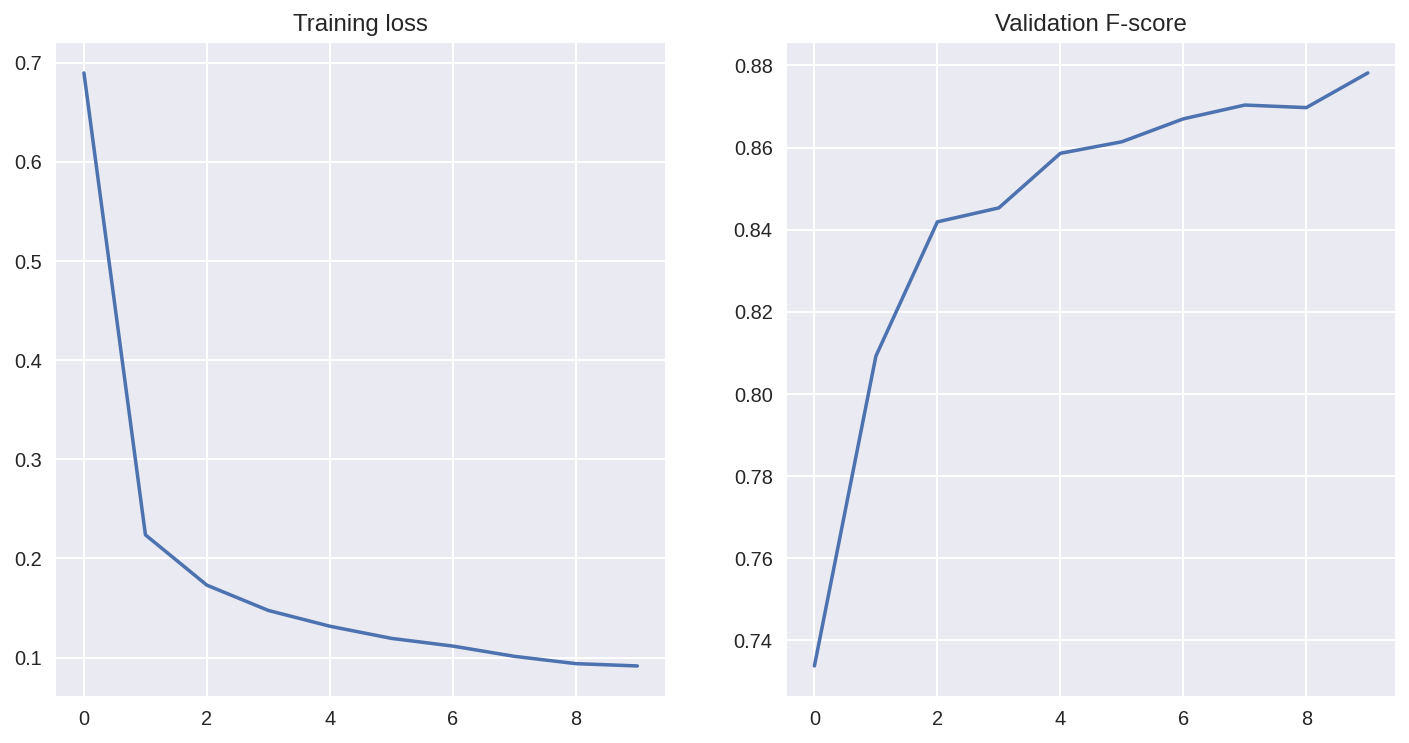

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system_bert.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system_bert.history['val_f1']);
ax[1].set_title('Validation F-score')
plt.show()

In [ ]:
ner_system_bert.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O',
  'O',
  'O',
  'O',
  'B-Disease',
  'I-Disease',
  'I-Disease',
  'I-Disease',
  'O',
  'B-Disease',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [ ]:
ner_util.show_entities(ner_system_bert, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

### A domain-specific BERT model

In [ ]:
model_name = 'dmis-lab/biobert-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
ner_system_bio = ner_util.SequenceLabeler(BERTParameters(), BERTSequenceModel,
                                      bert_tokenizer=tokenizer)
ner_system_bio.fit(Xtrain, Ytrain, Xval, Yval)

.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 1: train loss = 0.6881, val f1: 0.7457, time = 93.6903
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
.................................................. (100)
............................................
Epoch 2: train loss = 0.2295, val f1: 0.8065, time = 94.1224
.................................................. (50)
.................................................. (100)
...........................................
.................................................. (50)
...................................

0.8786375492251828

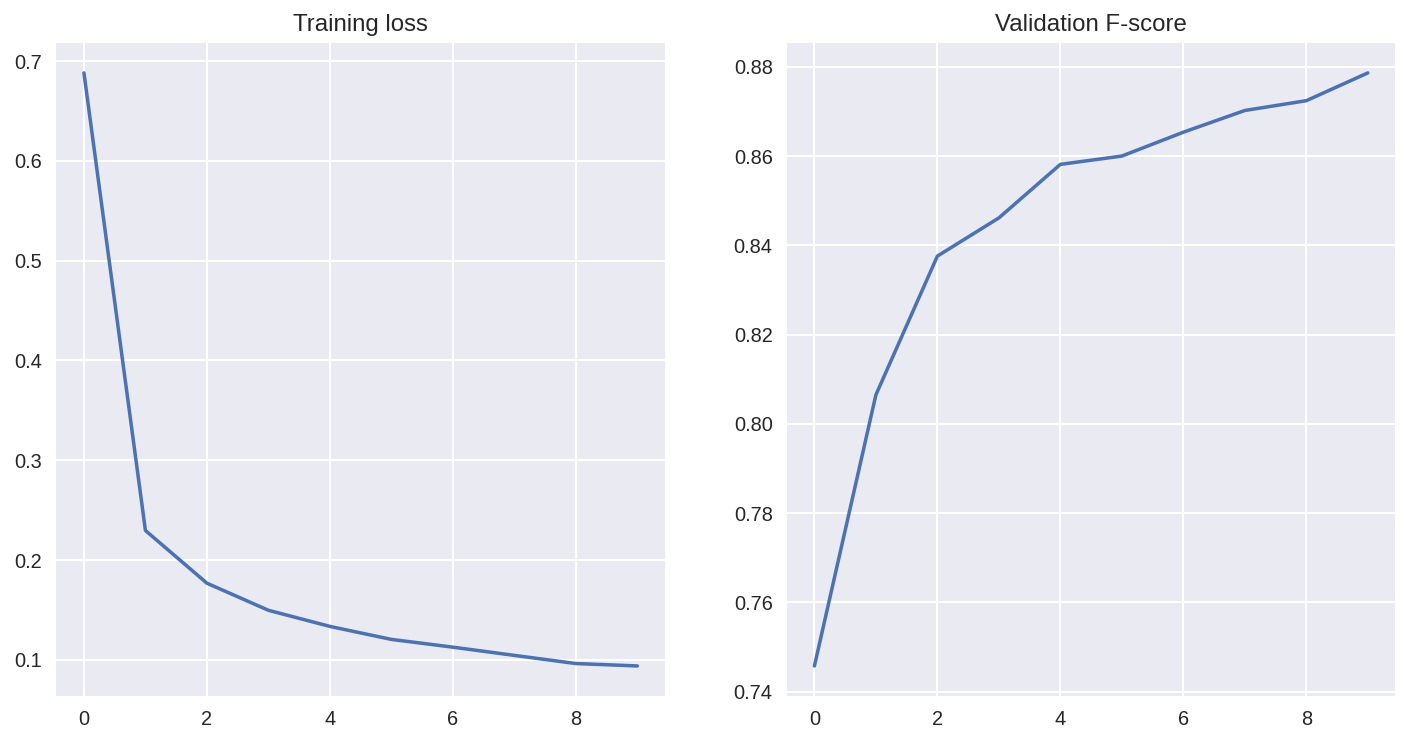

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system_bio.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system_bio.history['val_f1']);
ax[1].set_title('Validation F-score')
plt.show()

In [ ]:
ner_system_bio.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O',
  'O',
  'O',
  'O',
  'B-Disease',
  'I-Disease',
  'I-Disease',
  'I-Disease',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [ ]:
ner_util.show_entities(ner_system_bio, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

### Comparison

>  Compare the result to what you got when using the standard BERT model. 

As we can see in the results above and in the Table below, we can see a significant difference between a BERT model trained "from scratch" and a domain-specific one.
In our experiments, we see a difference in F1 score of around 5.4% points.

| Model | F1 Score |
| --- | --- |
| bert | 0.8244 |
| bio | 0.8786 |

# Conclusions

>  Run the biomedical entity recognizer interactively on some test sentences. What are your impressions? 

In [ ]:
ner_util.show_entities(ner_system_bio, ['The doctor prescribed an aspirin to be taken against the headache.'.split()])

In [ ]:
ner_util.show_entities(ner_system_bio, ['COVID-19 cannot be fought with Aciclovir.'.split()])

In [ ]:
ner_util.show_entities(ner_system_bio, ['COVID-19 cannot be fought with Beclometasone inhalers.'.split()])

The model is really impressive, and able to recognize most of the deseases and drugs. However, it seems unable to recognize more recent deseases like COVID-19, even when it appears in a sentence using words like "fought" and a recognized drug. Sorprizingly, the context is still not enough for the model to correctly label the "COVID-19" tokens.